In [1]:
import boto3
import json
import io
import cv2

In [2]:
import numpy as np
from IPython.display import Image as IImage
from skimage.exposure import is_low_contrast

In [3]:
from PIL import Image, ImageDraw, ExifTags, ImageColor
from matplotlib.pyplot import imshow

Matplotlib is building the font cache; this may take a moment.


## Examples of acceptable of face profile
 
### Capture 5 images at different face angles
### 1. Front view with head and shoulder

In [6]:
path = "./media/"

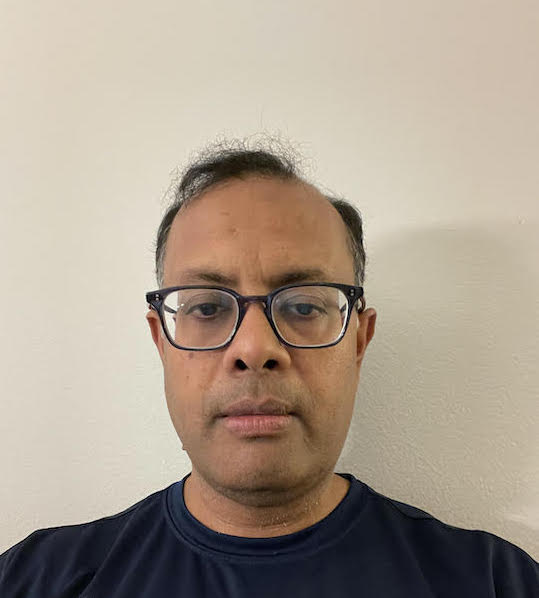

In [7]:
photo = path + 'photo1.jpeg'
IImage(filename=photo)

### Create Image Check Function 

In [8]:
rekognition = boto3.client('rekognition')

In [9]:
def image_check (photo):
    
    with open(photo, 'rb') as image:
        response = rekognition.detect_faces(Image={'Bytes': image.read()},Attributes=['ALL'])
    
    
    #perform image check
    image = Image.open(photo)
    imgWidth, imgHeight = image.size
    
    # Exception
    try:
        faceDetail = response['FaceDetails'][0]
        pitch = faceDetail['Pose']['Pitch']
        yaw = faceDetail['Pose']['Yaw']
        sunglasses = faceDetail['Sunglasses']['Value']
        box = faceDetail['BoundingBox']
        width = imgWidth * box['Width']
        height = imgHeight * box['Height']
        eyesOpen = faceDetail['EyesOpen']['Value']
        emotion = faceDetail['Emotions'][0]['Type']
        emotionConfidence = faceDetail['Emotions'][0]['Confidence']
        mouthOpen = faceDetail['MouthOpen']['Value']
        image_results = ""

        if (width < 50) or (height < 50):
            image_results += f'Face dimensions should be > 50x50 pixels. They are {width:.1f} x {height:.1f}\n'

        if (abs(yaw) > 45):
            image_results += f'Yaw (side face rotation) should be less than 45 degrees. It is {abs(yaw)} \n'

        if ((pitch > 45)):
            image_results += f'Pitch (looking up) should be less than 45 degrees. It is {pitch} \n'

        if ((pitch < -30)):
            image_results += f'Pitch (looking down) should be less than 30 degrees. It is {pitch} \n'

        if not eyesOpen:
            image_results += f'Eyes are not open \n'

        if sunglasses:
            image_results += f'remove sunglasses \n'

        if (mouthOpen):
            image_results += f'Mouth should be closed \n'

        # if no entry in image results, then image is compliant
        if (not image_results):
            image_results = "Image is compliant"
    
    except IndexError as e:
        print(f"Error: {e}")
        image_results = 'There is no face dateil info'
        
        
    return image_results

In [10]:
# Return Image check result

image_result = image_check(photo)

print("Image Check Result: ", image_result)

Image Check Result:  Image is compliant


### Create low contrast check function

In [11]:
def low_contrast_check(photo):
    image = cv2.imread(photo)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return is_low_contrast(gray, fraction_threshold=0.35)

In [12]:
# Return Image contrast result

result = 'Good contrast' if not low_contrast_check(photo) else 'Low contrast'

print('Image contrast Result: ', result)

Image contrast Result:  Good contrast


### Create show faces function
#### - make bounding box

In [13]:
%matplotlib inline

def show_faces(photo):

        # Load image
        print(f'photo = {photo}')

        with open(photo, 'rb') as image:

            # Call DetectFaces
            response = rekognition.detect_faces(
                Image={
                    'Bytes': image.read()
                },
                Attributes=['ALL']
            )

            image = Image.open(photo)

            img_width, img_height = image.size
            print('image width: ', img_width)
            print('image_height: ', img_height)

            draw = ImageDraw.Draw(image)

            # calculate and display bounding boxes for each detected face
            print('Detected faces for: ' + photo)

            for faceDetail in response['FaceDetails']:
                print('The detected face is between ' + str(faceDetail['AgeRange']['Low']) 
                          + ' and ' + str(faceDetail['AgeRange']['High']) + ' years old')

                box = faceDetail['BoundingBox']

                left = img_width * box['Left']
                top = img_height * box['Top']
                width = img_width * box['Width']
                height = img_height * box['Height']

                print('Left: ', left)
                print('Top: ', top)
                print('Face Width: ', width)
                print('Face Height: ', height)

                # Set bounding box points
                points = (
                    (left, top),
                    (left + width, top),
                    (left + width, top + height),
                    (left, top + height),
                    (left, top)
                )

                draw.line(points, fill='#00d400', width=10)

            imshow(np.asarray(image))
        
            return len(response['FaceDetails'])

photo = ./media/photo1.jpeg
image width:  539
image_height:  598
Detected faces for: ./media/photo1.jpeg
The detected face is between 42 and 50 years old
Left:  158.06711223721504
Top:  185.09105676412582
Face Width:  205.1512739956379
Face Height:  305.82243025302887


1

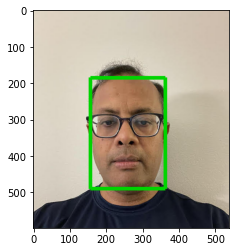

In [14]:
show_faces(photo)

### Summarize the above function into one func

In [15]:
# Summarize function

def image_summarize(photo_file=None):
    
    # Set photo path
    photo = path + photo_file
    
    print()
    # Show Original Image
    IImage(filename=photo)
    
    print()
    print('##########Image Detail Info##########')
    show_faces(photo)
    
    print()
    print('##########Image Compatibility Check##########')
    print(image_check(photo))
    
    print()
    print('##########Image Contrast Check##########')
    result = 'Good contrast' if not low_contrast_check(photo) else 'Low contrast'
    print(f'Image has {result}')
    

### 2. Face turned right with head and shoulder



##########Image Detail Info##########
photo = ./media/photo3.jpeg
image width:  539
image_height:  549
Detected faces for: ./media/photo3.jpeg
The detected face is between 40 and 48 years old
Left:  157.70452800393105
Top:  172.3793630003929
Face Width:  185.37557458877563
Face Height:  267.83526769280434

##########Image Compatibility Check##########
Image is compliant

##########Image Contrast Check##########
Image has Good contrast


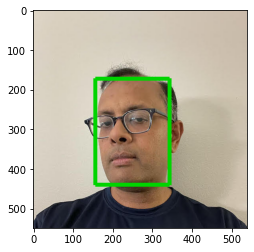

In [16]:
image_summarize(photo_file='photo3.jpeg')

### 3. Face turned left with head and shoulder



##########Image Detail Info##########
photo = ./media/photo2.jpeg
image width:  539
image_height:  458
Detected faces for: ./media/photo2.jpeg
The detected face is between 41 and 49 years old
Left:  189.15408396720886
Top:  98.99440038204193
Face Width:  164.04189705848694
Face Height:  231.128688454628

##########Image Compatibility Check##########
Image is compliant

##########Image Contrast Check##########
Image has Good contrast


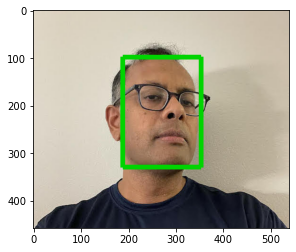

In [17]:
image_summarize(photo_file='photo2.jpeg')

### 4. Face turned up slightly with head and shoulder



##########Image Detail Info##########
photo = ./media/photo4.jpeg
image width:  540
image_height:  546
Detected faces for: ./media/photo4.jpeg
The detected face is between 43 and 51 years old
Left:  202.0862102508545
Top:  131.43575817346573
Face Width:  188.48385393619537
Face Height:  216.43619245290756

##########Image Compatibility Check##########
Image is compliant

##########Image Contrast Check##########
Image has Good contrast


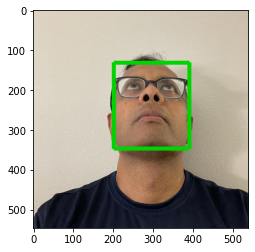

In [18]:
image_summarize(photo_file='photo4.jpeg')

### 5. Face turned down slightly with head and shoulder



##########Image Detail Info##########
photo = ./media/photo5.jpeg
image width:  539
image_height:  543
Detected faces for: ./media/photo5.jpeg
The detected face is between 45 and 51 years old
Left:  161.53317141532898
Top:  141.32152837514877
Face Width:  246.05367335677147
Face Height:  351.00463700294495

##########Image Compatibility Check##########
Image is compliant

##########Image Contrast Check##########
Image has Good contrast


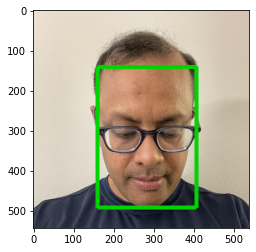

In [19]:
image_summarize(photo_file='photo5.jpeg')

## Examples of unacceptable face profile



##########Image Detail Info##########
photo = ./media/photo6.jpeg
image width:  540
image_height:  540
Detected faces for: ./media/photo6.jpeg
The detected face is between 35 and 43 years old
Left:  240.2298617362976
Top:  124.78101700544357
Face Width:  174.806889295578
Face Height:  271.10795617103577

##########Image Compatibility Check##########
Yaw (side face rotation) should be less than 45 degrees. It is 58.711387634277344 
Pitch (looking up) should be less than 45 degrees. It is 65.32157135009766 


##########Image Contrast Check##########
Image has Good contrast


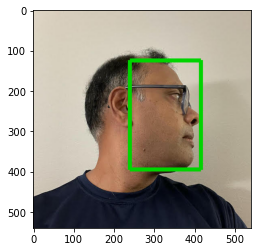

In [20]:
image_summarize(photo_file='photo6.jpeg')



##########Image Detail Info##########
photo = ./media/photo7.jpeg
image width:  539
image_height:  517
Detected faces for: ./media/photo7.jpeg
The detected face is between 36 and 44 years old
Left:  67.56226772069931
Top:  99.7937364578247
Face Width:  187.85874328017235
Face Height:  275.3744384050369

##########Image Compatibility Check##########
Yaw (side face rotation) should be less than 45 degrees. It is 61.3838005065918 
Pitch (looking up) should be less than 45 degrees. It is 51.41620635986328 


##########Image Contrast Check##########
Image has Good contrast


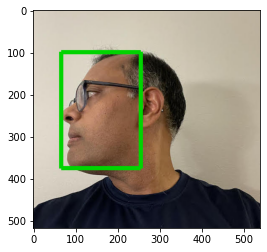

In [21]:
image_summarize(photo_file='photo7.jpeg')



##########Image Detail Info##########
photo = ./media/photo8.jpeg
image width:  540
image_height:  720
Detected faces for: ./media/photo8.jpeg
The detected face is between 13 and 21 years old
Left:  189.33608829975128
Top:  351.01288318634033
Face Width:  179.86947298049927
Face Height:  157.75023937225342

##########Image Compatibility Check##########
Pitch (looking down) should be less than 30 degrees. It is -61.015499114990234 
Eyes are not open 


##########Image Contrast Check##########
Image has Good contrast


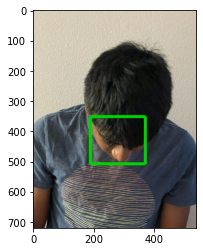

In [22]:
image_summarize(photo_file='photo8.jpeg')



##########Image Detail Info##########
photo = ./media/photo9.jpeg
image width:  540
image_height:  720
Detected faces for: ./media/photo9.jpeg

##########Image Compatibility Check##########
Error: list index out of range
There is no face dateil info

##########Image Contrast Check##########
Image has Good contrast


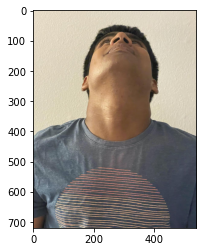

In [23]:
image_summarize(photo_file='photo9.jpeg')

### Example of less than 50x50 pixels covering the face



##########Image Detail Info##########
photo = ./media/photo13.jpeg
image width:  540
image_height:  720
Detected faces for: ./media/photo13.jpeg
The detected face is between 36 and 44 years old
Left:  290.9145998954773
Top:  617.6526975631714
Face Width:  9.837341532111168
Face Height:  14.165039509534836

##########Image Compatibility Check##########
Face dimensions should be > 50x50 pixels. They are 9.8 x 14.2


##########Image Contrast Check##########
Image has Good contrast


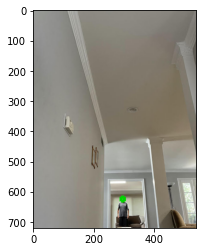

In [24]:
image_summarize(photo_file='photo13.jpeg')

### Example of occlusions
### - Avoid sunglasses, masks, headbands and hat



##########Image Detail Info##########
photo = ./media/photo10.jpeg
image width:  540
image_height:  640
Detected faces for: ./media/photo10.jpeg
The detected face is between 42 and 50 years old
Left:  164.64633285999298
Top:  129.07293319702148
Face Width:  252.18661844730377
Face Height:  375.65208435058594

##########Image Compatibility Check##########
remove sunglasses 


##########Image Contrast Check##########
Image has Good contrast


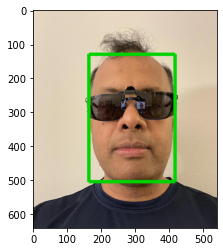

In [25]:
image_summarize(photo_file='photo10.jpeg')

### Example of low contrast image



##########Image Detail Info##########
photo = ./media/photo12.jpeg
image width:  540
image_height:  720
Detected faces for: ./media/photo12.jpeg
The detected face is between 22 and 30 years old
Left:  109.46020692586899
Top:  193.3780860900879
Face Width:  325.3373944759369
Face Height:  472.2240114212036

##########Image Compatibility Check##########
Eyes are not open 


##########Image Contrast Check##########
Image has Low contrast


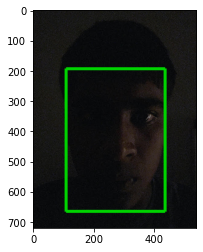

In [26]:
image_summarize(photo_file='photo12.jpeg')

## References

- https://docs.aws.amazon.com/rekognition/latest/dg/recommendations-facial-input-images.html
- https://docs.aws.amazon.com/rekognition/latest/dg/best-practices.html
- https://catalog.us-east-1.prod.workshops.aws/workshops/4a2a9a24-071d-4d96-b9be-0cc57b7db434/en-US/rek-apis/celebrity-recognition